In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
!pip install mecab-python3

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import MeCab

import time
import re
import os
import io
from tqdm import tqdm
import random

from utils import *
from models import Encoder, Decoder
from loss import loss_function

In [3]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 데이터 다운로드

In [4]:
path_to_dir = os.getenv('HOME') + "/aiffel/s2s_translation/data/"

path_to_train_kor = path_to_dir + "korean-english-park.train.ko"
path_to_train_eng = path_to_dir + "korean-english-park.train.en"

path_to_test_kor = path_to_dir + "korean-english-park.test.ko"
path_to_test_eng = path_to_dir + "korean-english-park.test.en"

In [5]:
src_train = read_data(path_to_train_kor)
tgt_train = read_data(path_to_train_eng)

src_test = read_data(path_to_test_kor)
tgt_test = read_data(path_to_test_eng)

In [6]:
print(len(src_train))
print(len(src_test))

94123
2000


In [7]:
# 데이터 중복 제거
unique_pairs = set(zip(src_train, tgt_train))
corpus_train = list(unique_pairs)

print(len(corpus_train))

78968


### 데이터 전처리

In [8]:
enc_corpus_train = []
dec_corpus_train = []

for pair in corpus_train:
    kor, eng = pair[0], pair[1]
    kor_preprocessed = preprocess_kor(kor)
    eng_preprocessed = preprocess_eng(eng)
    
    # 전처리 후 샘플에 단어가 없을 경우는 append x
    if len(kor_preprocessed) != 0 and len(eng_preprocessed) > 2:
        enc_corpus_train.append(kor_preprocessed)
        dec_corpus_train.append(eng_preprocessed)

In [9]:
print("Korean:", enc_corpus_train[1972])
print("English:", dec_corpus_train[1972])

print(len(enc_corpus_train))
print(len(dec_corpus_train))

Korean: 이 성명은 유엔에 제출할 대북 제재보고서를 작성한 이후 나왔다
English: <start> the announcement came as nations finalize reports to the un on imposing sanctions against north korea <end>
78891
78891


In [10]:
# 토큰화하기
enc_input_tok, enc_tokenizer = tokenize_kor(enc_corpus_train)
dec_input_tok, dec_tokenizer = tokenize_eng(dec_corpus_train)

In [11]:
max_len = 50

enc_input = []
dec_input = []

for enc, dec in zip(enc_input_tok, dec_input_tok):
    if len(enc) <= max_len and len(dec) <= max_len:
        enc_input.append(enc)
        dec_input.append(dec)

In [12]:
enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, 
                                                          maxlen=max_len,
                                                          padding='post')
dec_input = tf.keras.preprocessing.sequence.pad_sequences(dec_input, 
                                                        maxlen=max_len,
                                                        padding='post')

In [13]:
# train_test_split을 활용해서 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val = train_test_split(enc_input, test_size=0.2)
dec_train, dec_val = train_test_split(dec_input, test_size=0.2)

### 모델 설계

In [14]:
BATCH_SIZE = 256
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = max_len

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (256, 50, 512)
Decoder Output: (256, 1, 47144)
Decoder Hidden State: (256, 512)
Attention: (256, 50, 1)


### 학습 & 추론

In [15]:
optimizer = tf.keras.optimizers.Adam(0.0002)

In [16]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    batch_size = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * batch_size, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [17]:
# Define eval_step
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process with validation

EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Epoch  8:  99%|█████████▊| 233/236 [04:36<00:03,  1.19s/it, Loss 2.7329]


KeyboardInterrupt: 

### 번역 결과 확인

Input: 만약 당신이 공항에서 탄 택시가 시내까지 가는데 20분 이상이 소요된다면 택시 운전자가 일부러 길을 돌아서 가는 것이라고 판단해야 한다고 라스베이거스 경찰관인 호세 몬토야가 밝혔다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_137/2775839936.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_137/2775839936.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


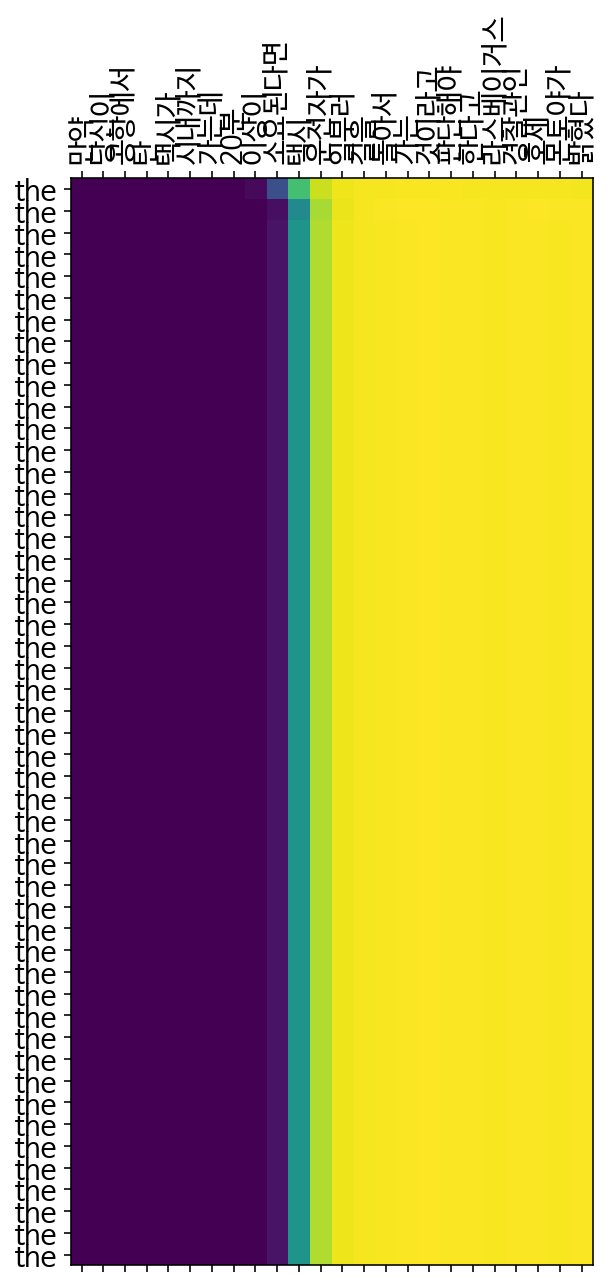

Input: 네바다주 당국은 이 같은 편법 운행이 증가하고 있다며 관광객들의 주의를 당부했다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


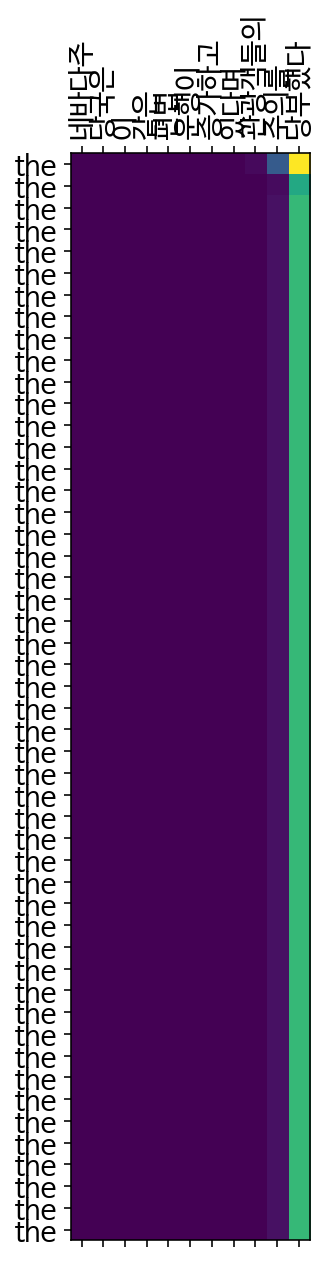

Input: 경찰은 택시에서 피해를 당했을 경우 에 신고하라고 밝혔다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


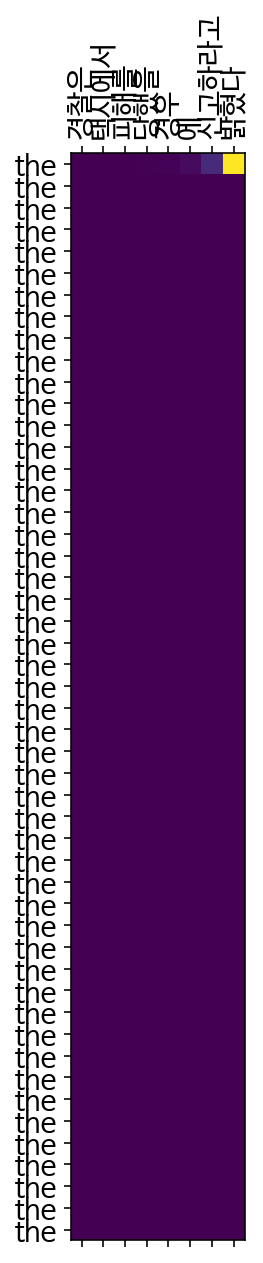

Input: 런던에서는 시 당국으로부터 정식으로 허가를 받은 검정색 택시를 골라야 하며 야간 에 바 레스토랑 극장 밖에서 대기하고 있는 소형택시 는 피하는 것이 좋다고 앨런 크로포드 런던 경찰청 대변인이 밝혔다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


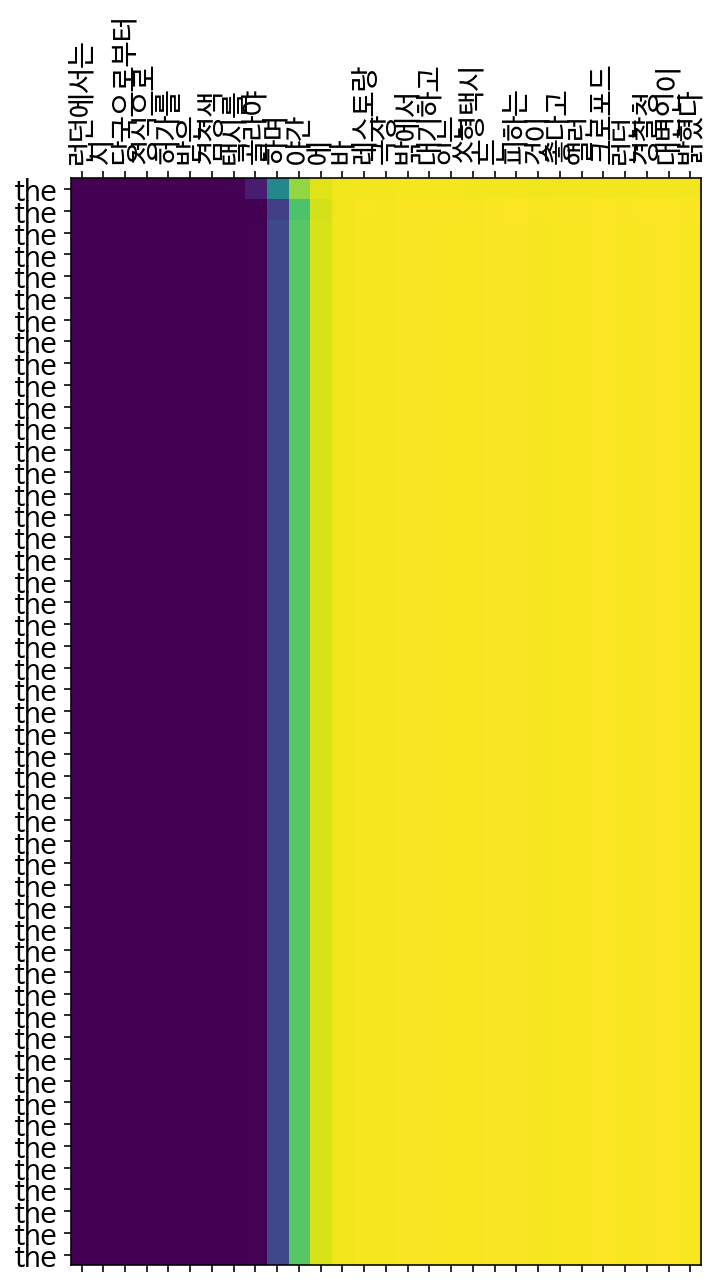

Input: 런던 경찰청 통계자료에 의하면 지난 2006년의 경우 런던에서 10명의 여성이 소형택시를 탔다가 성폭행을 당했다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


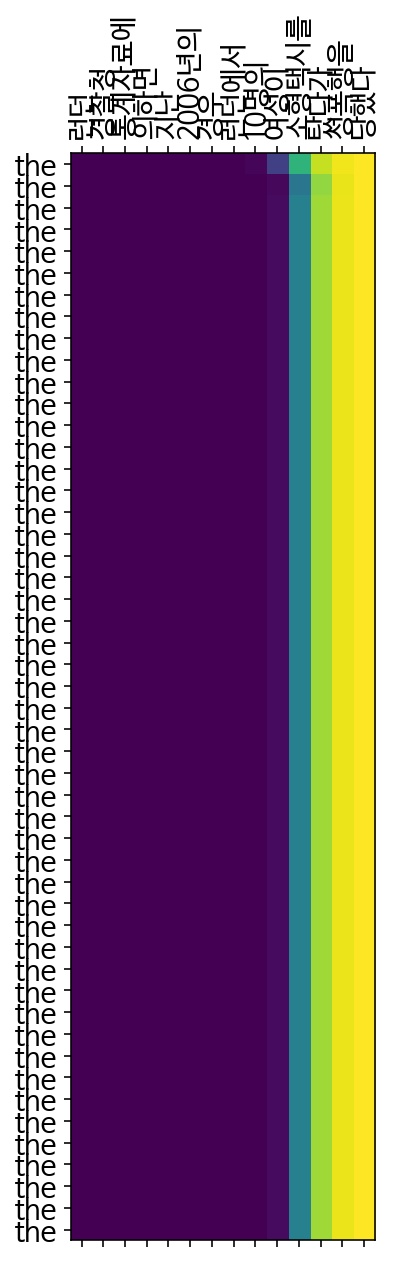

Input: 이들 소형택시 는 예약을 한 승객들만 받을 수 있으며 거리에서 사람들을 태우는 것은 엄연히 불법이다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


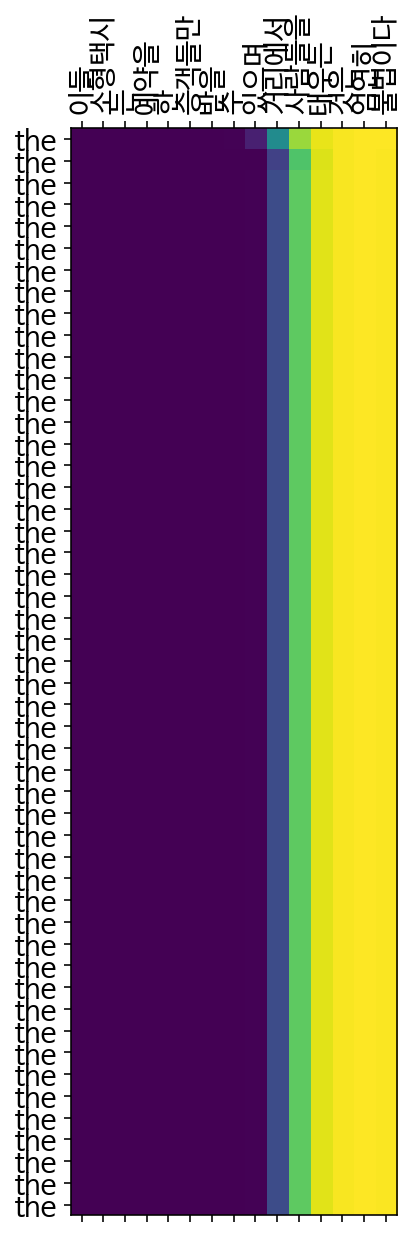

Input: 경찰 지휘관인 알랭 시모노는 몬트리올에서 문이 잠기지 않은 차량의 노트북 아이팟 스테레오 등을 훔치는 범죄자 자주 일어나고 있다고 경고했다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


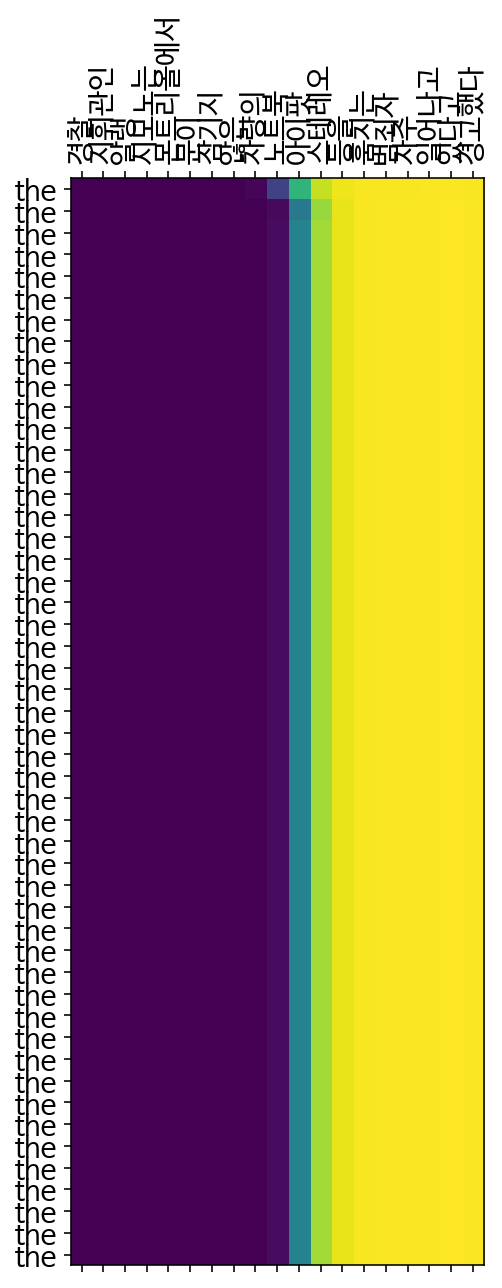

Input: 시모노는 몬트리올에서 차량범죄가 자주 일어나고 있다며 관광객들이 자동차를 주차한 뒤 차 안은 물론 트렁크의 물건까지 다 챙겨야 한다고 강조했다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


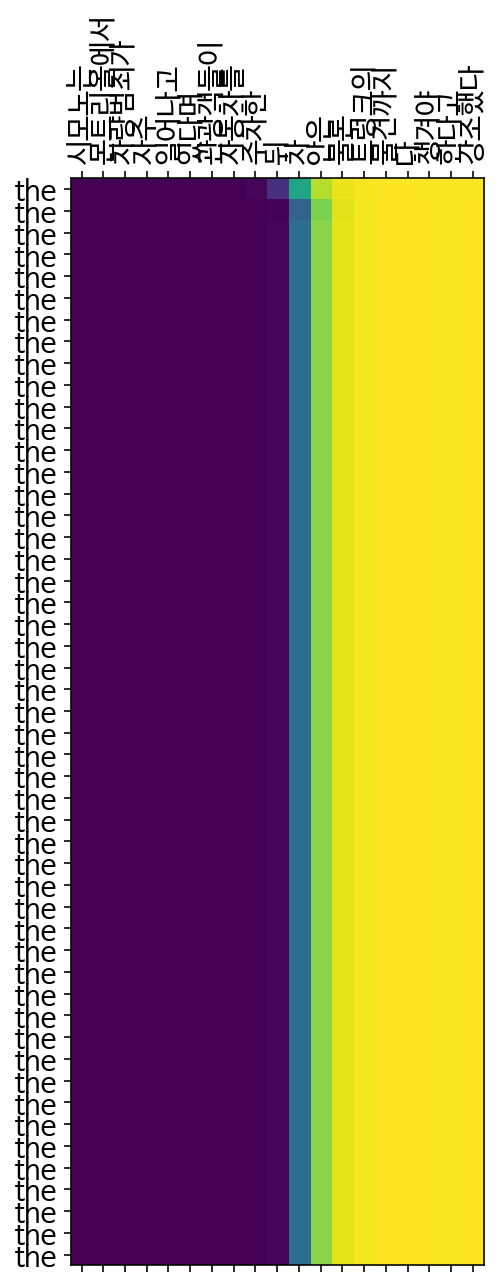

Input: 현지경찰은 외국인이 자주 이용하는 레스토랑과 자동차 유리창에 이런 안내사항이 담긴 팜플렛을 배치하기 시작했다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


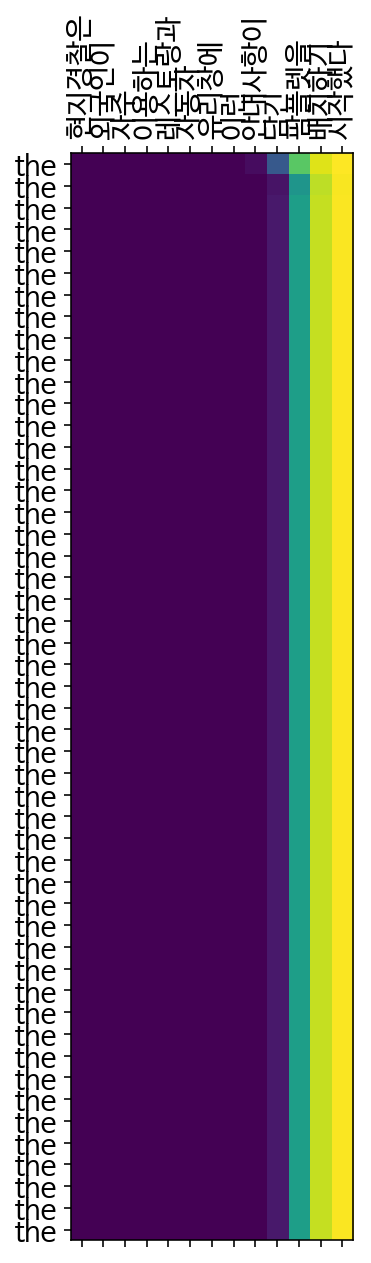

Input: 퀘벡주에서는 자동차를 주차한 뒤 문을 잠그지 않고 그냥 가다가 적발될 경우 30달러의 벌금을 납부해야 한다
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


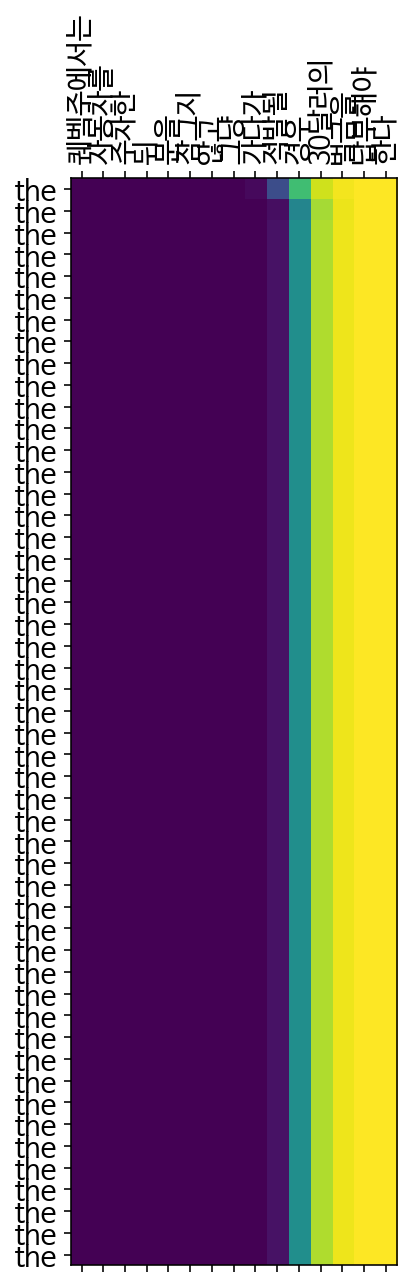

In [18]:
def mecab_tokenize(sentence):
    mecab = MeCab.Tagger()
    # MeCab으로 토큰화한 결과를 공백으로 구분된 단어 리스트로 변환
    tokens = mecab.parse(sentence).splitlines()
    tokens = [token.split('\t')[0] for token in tokens if token != '']
    return tokens

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    # 한글 전처리 적용
    sentence = preprocess_kor(sentence)
    
    # MeCab으로 토큰화
    sentence_tokens = mecab_tokenize(sentence)
    
    # 토큰화된 문장을 숫자 시퀀스로 변환
    inputs = enc_tokenizer.texts_to_sequences([sentence_tokens])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    result = ''

    # 인코더 처리
    enc_out = encoder(inputs)

    # 디코더 초기 상태 설정
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention[t] = attention_weights.numpy()

        # 예측된 단어를 선택
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0], axis=-1).numpy()  # Shape: (batch_size,)
        predicted_id = predicted_id[0]

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


for text in src_test[800:810]:
    translate(text, encoder, decoder)

### 회고

#### 개선'한' 점

##### 1) 데이터 전처리

1. 중복 제거를 어떻게 할까?
    - 기존의 방식 : source, target 둘 다 겹치면 중복으로 간주  
    - 대안 : source만 겹쳐도 중복으로 간주
        - 같은 source, 다른 target을 가진 pair들 중에 무엇을 선택할 것인지에 대한 문제가 있음.
        - 중복 데이터가 많아져 데이터 수가 기존 방식에 비해 줄어듦
        - 오히려 같은 한국어 문장이 다양하게 번역될 수 있다는 점을 학습시킬 수 없어 모델이 표현 다양성을 학습하는 데 제한이 생길 수 있음.
    
**=> source, target 둘 다 겹치면 중복처리하는 기존 방식 유지**  

2. 전처리 함수
    - source & target dataset EDA
    - 일부 특수기호를 단어로 변경
    - 숫자를 살리는 대신, ',', '.', 괄호 안 단어 등을 추가로 제거  
    
3. 토큰화 -> 문장 길이 제한으로 순서 변경


##### 2) 모델 설계

1. Encoder & Decoder
    - gru layer를 여러 개 쌓는 로직 추가
    - 어텐션은 decoder의 마지막 layer에만 적용

#### 개선'할' 점

##### 1) 모델 설계

1. Attention module
    - Luong attention 구현해보고 Bahdanau와 성능 비교
 

##### 2) 훈련 & 추론

1. hyperparameter tuning
    - embedding_dim
    - num_units
    - batch_size
    - learning_rate

2. callback 추가
    - checkpoint
    - early stopping